In [1]:
import json
from textwrap import wrap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

from statsmodels.stats.inter_rater import fleiss_kappa

from scipy.stats import kendalltau, mode
from correlation import goodman_kruskal_gamma, goodman_kruskal_concordance

import stanza

In [2]:
LANG = 'en' # one of 'fi', 'ru', 'en'

In [3]:
tokenizer = stanza.Pipeline(lang=LANG, processors='tokenize,mwt,pos' if LANG == 'fi' else 'tokenize,pos')

2021-03-16 16:26:53 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |

2021-03-16 16:26:54 INFO: Use device: gpu
2021-03-16 16:26:54 INFO: Loading: tokenize
2021-03-16 16:26:55 INFO: Loading: pos
2021-03-16 16:26:56 INFO: Done loading processors!


In [4]:
d = json.load(open('{}.json'.format(LANG), encoding='utf-8-sig'))

In [5]:
answer_groups = ["\n".join(wrap(x['answer_group'], 30)) for x in list(d['responses'][0]['responses'].values())[0]]
ideal = {x: y for x, y in zip(answer_groups, [4, 4, 1, 1, 4, 4, 1, 1, 1])}
gold_sentences = [k for k, v in d['responses'][0]['responses'].items() if v[0]['extra']['model'] == 'gold']
gen_sentences = [k for k, v in d['responses'][0]['responses'].items() if v[0]['extra']['model'] == 'gen']

The questions are generated from exactly the same sentences, so sentence length distribution is irrelevant.

In [6]:
gold_q_lengths = np.array([len([w for s in tokenizer(gs.split('<br>')[1].replace('Question: ', '')).sentences
                       for w in s.tokens]) for gs in gold_sentences])

<AxesSubplot:ylabel='Count'>

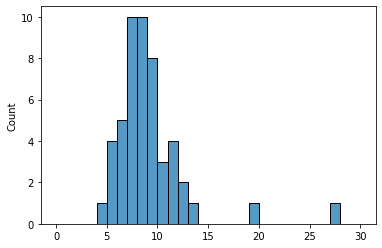

In [7]:
sns.histplot(gold_q_lengths, binrange=(0,30), binwidth=1)

In [8]:
gen_q_lengths = np.array([len([w for s in tokenizer(gs.split('<br>')[1].replace('Question: ', '')).sentences
                       for w in s.tokens]) for gs in gen_sentences])

<AxesSubplot:ylabel='Count'>

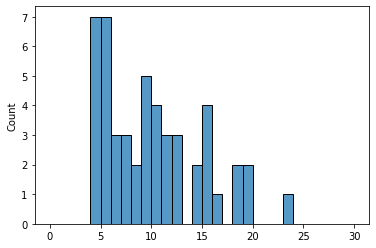

In [9]:
sns.histplot(gen_q_lengths, binrange=(0,30), binwidth=1)

In [10]:
gold = [pd.DataFrame.from_dict({
    k: [x['value'] for x in v] 
    for k, v in r['responses'].items() if v[0]['extra']['model'] == 'gold'
}, orient='index', columns=answer_groups) for r in d['responses']]

In [11]:
gen = [pd.DataFrame.from_dict({
    k: [x['value'] for x in v] 
    for k, v in r['responses'].items() if v[0]['extra']['model'] == 'gen'
}, orient='index', columns=answer_groups) for r in d['responses']]

In [12]:
def calc_multirater_gamma(arr):
    U = len(arr)
    gamma = []
    for ag in answer_groups:
        C, D = 0, 0
        for i in range(U):
            for j in range(U):
                c, d, t = goodman_kruskal_concordance(
                    arr[i].loc[:,ag].sort_index(),
                    arr[j].loc[:,ag].sort_index()
                )
                C += c
                D += d
        N = arr[i].shape[0]
        G = (C - D) / (C + D)
        gamma.append([ag.replace('\n', ' '), G, G * np.sqrt((C + D) / (U * N * (1 - G**2)))])
    return pd.DataFrame(gamma, columns=['criterion', 'multi-gamma', 'z'])

In [13]:
calc_multirater_gamma(gold)

,criterion,multi-gamma,z
0,The question is grammatically correct.,0.533319,2.767449
1,The question makes sense.,0.548128,3.269645
2,The question would be clearer if more informat...,0.437040,3.163062
3,The question would be clearer if less informat...,0.474425,2.471839
4,The question is relevant to the given sentence.,0.640164,5.693752
5,The suggested answer correctly answers the que...,0.751116,7.842128
6,The suggested answer would be clearer if phras...,0.274813,2.025395
7,The suggested answer would be clearer if more ...,0.378692,2.853030
8,The suggested answer would be clearer if less ...,0.671924,3.064826


In [14]:
calc_multirater_gamma(gen)

,criterion,multi-gamma,z
0,The question is grammatically correct.,0.629404,6.695996
1,The question makes sense.,0.720851,8.436627
2,The question would be clearer if more informat...,0.472666,4.267114
3,The question would be clearer if less informat...,0.542506,2.948419
4,The question is relevant to the given sentence.,0.546073,4.921136
5,The suggested answer correctly answers the que...,0.730102,8.767939
6,The suggested answer would be clearer if phras...,0.417940,3.459349
7,The suggested answer would be clearer if more ...,0.419343,3.032384
8,The suggested answer would be clearer if less ...,0.660797,2.586638


In [15]:
def calc_gkgamma(arr, answer_group):
    N = len(arr)
    corr, ties = np.zeros(shape=(N, N)), np.zeros(shape=(N, N))
    for i in range(N):
        for j in range(i, N):
            res = goodman_kruskal_gamma(arr[i].loc[:,answer_group].sort_index().to_numpy(),
                                        arr[j].loc[:,answer_group].sort_index().to_numpy())
            corr[i][j] = res['correlation']
            ties[i][j] = res['ties']
    return pd.DataFrame(corr), pd.DataFrame(ties)

In [16]:
def plot_per_participant(arr):
    for i in range(len(arr)):
        dfm = arr[i].melt(var_name='statement')
        g = sns.FacetGrid(dfm, col='statement', col_wrap=3)
        g = (g.map(sns.histplot, 'value', binrange=(0.25, 4.25), binwidth=0.5))
        g.set_titles(row_template='{row_name}', col_template='{col_name}')
        plt.savefig('gen_annotator_{}.pdf'.format(i))

In [17]:
def multiannotate(ax, s, xy_arr=[], *args, **kwargs):
    ans = []
    an = ax.annotate(s, xy_arr[0], *args, **kwargs)
    ans.append(an)
    for xy in xy_arr[1:]:
        an = ax.annotate(s, xy, alpha=0.0, *args, **kwargs)
        ans.append(an)
    return ans

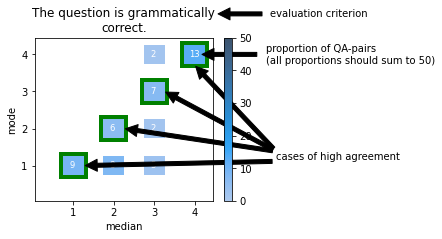

In [18]:
def plot_explanation():
    df_concat = pd.concat(gen).melt(ignore_index=False)
    df_agg = df_concat.groupby([df_concat.index, 'variable']).agg('median')
    df_agg.columns = ['median']
    df_agg = df_agg.unstack('variable')
    df_agg.columns = df_agg.columns.droplevel(0)
    df_agg = df_agg.reindex(columns=answer_groups).melt(ignore_index=False)
    # in case of multiple modes the worst one is returned
    # this is done by subtracting 5 - x of those where 1 is the best value
    # then scipy.stats.mode returns the smallest mode
    # and then we transform the modes back afterwards
    mask = df_concat['variable'].apply(lambda x: ideal[x]) == 1
    df_concat.loc[mask,'value'] = df_concat[mask]['value'].apply(lambda x: 5 - x)
    df_agg2 = df_concat.groupby([df_concat.index, 'variable']).agg(lambda x: mode(x).mode)
    mask = df_agg2.index.map(lambda x: ideal[x[1]] == 1)
    df_agg2.loc[mask, 'value'] = df_agg2.loc[mask, 'value'].apply(lambda x: 5 - x)
    df_agg2.columns = ['mode']
    df_agg2 = df_agg2.unstack('variable')
    df_agg2.columns = df_agg2.columns.droplevel(0)
    df_agg2 = df_agg2.reindex(columns=answer_groups).melt(ignore_index=False)
    df = pd.concat([df_agg, df_agg2], axis=1)
    df.columns = ['criterion', 'median', 't', 'mode']
    df = df.drop(columns=['t'])
    df = df[df['criterion'] == answer_groups[0]]
    plt.rcParams['figure.figsize'] = (4,3)
    g = sns.histplot(data=df, x='median', y='mode', binrange=(0.25, 4.25), binwidth=0.5,
               cbar=True, vmin=0, vmax=gen[0].shape[0], color='C0')
    plt.title(answer_groups[0])
    plt.xticks(range(1, 5))
    plt.yticks(range(1, 5))
    ax = g.axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    Nx, Ny = int(xmax), int(ymax)
    for i, x in enumerate(ax.collections[0].get_array()):
        if x != '--':
            j = round((i - 1) / 4) - 1
            if i < 11: j = 0
            ax.text((j % Nx) + 0.85 + (0.05 if len(str(int(x))) == 1 else 0),
                    (j // Ny) + 0.95,
                        int(x), fontsize='small', c='white')
    ax.annotate('evaluation criterion', xy=(0.48, 0.94), xycoords='figure fraction',
                xytext=(0.61, 0.94), arrowprops=dict(facecolor='black', shrink=0.1),
                horizontalalignment='left', verticalalignment='center')
    ax.annotate('proportion of QA-pairs\n(all proportions should sum to 50)', xy=(4, 4), xycoords='data',
                xytext=(5.75, 4), arrowprops=dict(facecolor='black', shrink=0.1),
                horizontalalignment='left', verticalalignment='center')
    for i in range(4):
        rect = patches.Rectangle((0.69 + i, 0.68 + i), 0.62, 0.62, linewidth=4, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    multiannotate(ax, 'cases of high agreement', xycoords='data', arrowprops=dict(facecolor='black', shrink=0.01),
                 xytext=(6, 1.25), xy_arr=[(1.25,1), (2.25,2), (3.25,3), (4,3.7)],
                 horizontalalignment='left', verticalalignment='center')

    plt.savefig('histogram_explained.pdf', bbox_inches='tight')
plot_explanation()

In [19]:
def plot_median_vs_mode(arr, filename=None):
    df_concat = pd.concat(arr).melt(ignore_index=False)
    df_agg = df_concat.groupby([df_concat.index, 'variable']).agg('median')
    df_agg.columns = ['median']
    df_agg = df_agg.unstack('variable')
    df_agg.columns = df_agg.columns.droplevel(0)
    df_agg = df_agg.reindex(columns=answer_groups).melt(ignore_index=False)
    # in case of multiple modes the worst one is returned
    # this is done by subtracting 5 - x of those where 1 is the best value
    # then scipy.stats.mode returns the smallest mode
    # and then we transform the modes back afterwards
    mask = df_concat['variable'].apply(lambda x: ideal[x]) == 1
    df_concat.loc[mask,'value'] = df_concat[mask]['value'].apply(lambda x: 5 - x)
    df_agg2 = df_concat.groupby([df_concat.index, 'variable']).agg(lambda x: mode(x).mode)
    mask = df_agg2.index.map(lambda x: ideal[x[1]] == 1)
    df_agg2.loc[mask, 'value'] = df_agg2.loc[mask, 'value'].apply(lambda x: 5 - x)
    df_agg2.columns = ['mode']
    df_agg2 = df_agg2.unstack('variable')
    df_agg2.columns = df_agg2.columns.droplevel(0)
    df_agg2 = df_agg2.reindex(columns=answer_groups).melt(ignore_index=False)
    df = pd.concat([df_agg, df_agg2], axis=1)
    df.columns = ['criterion', 'median', 't', 'mode']
    df = df.drop(columns=['t'])
    g = sns.FacetGrid(df, col='criterion', col_wrap=3)
    g = (g.map(sns.histplot, 'median', 'mode', binrange=(0.25, 4.25), binwidth=0.5,
               cbar=True, vmin=0, vmax=arr[0].shape[0], color='C0'))
    g.set_titles(row_template='{row_name}', col_template='{col_name}')
    g.set(xticks=range(1, 5))
    for ax in g.axes.flat:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        Nx, Ny = int(xmax), int(ymax)
        for i, x in enumerate(ax.collections[0].get_array()):
            if x != '--':
                j = round((i - 1) / 4) - 1
                if i < 11: j = 0
                ax.text((j % Nx) + 0.85 + (0.05 if len(str(int(x))) == 1 else 0),
                        (j // Ny) + 0.95,
                        int(x), fontsize='small', c='white')
    if filename:
        plt.savefig(filename, bbox_inches='tight')

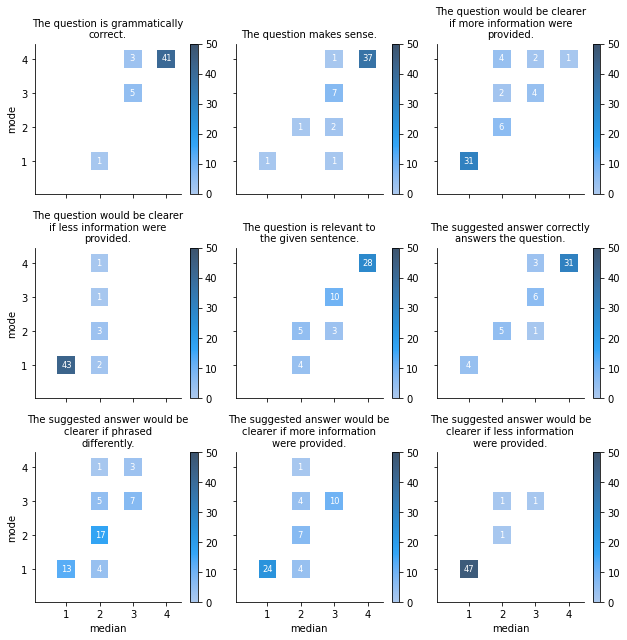

In [20]:
plot_median_vs_mode(gold, "{}_gold.pdf".format(LANG))

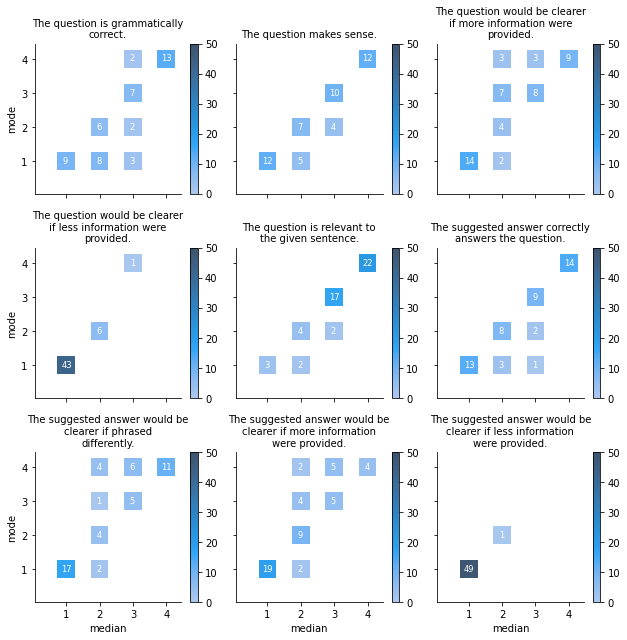

In [21]:
plot_median_vs_mode(gen, "{}_gen.pdf".format(LANG))

Marginals are considered to be fixed when raters know a priori the quantity of cases that should be distributed into each category.

Marginal distributions are considered to be free when raters do not know a priori the quantities of cases that should be distributed into each category.

Multirater (Randolph) κ is appropriate when one or more marginals are not fixed.

In [22]:
def calc_randolph_kappa(arr):
    fleiss = []
    for j in range(len(answer_groups)):
        user_ratings = pd.concat([arr[i].loc[:,answer_groups[j]].sort_index()
            for i in range(len(arr))], axis=1).apply(lambda x: x.value_counts(), axis=1).fillna(0)
        fleiss.append((answer_groups[j].replace('\n', ' '), fleiss_kappa(user_ratings, 'rand')))
    return pd.DataFrame(fleiss, columns=['criterion', 'randolph kappa'])

In [23]:
gold_kappa = calc_randolph_kappa(gold)
gold_kappa

,criterion,randolph kappa
0,The question is grammatically correct.,0.344000
1,The question makes sense.,0.248000
2,The question would be clearer if more informat...,0.152000
3,The question would be clearer if less informat...,0.410667
4,The question is relevant to the given sentence.,0.205333
5,The suggested answer correctly answers the que...,0.248000
6,The suggested answer would be clearer if phras...,0.029333
7,The suggested answer would be clearer if more ...,0.157333
8,The suggested answer would be clearer if less ...,0.525333


In [24]:
gen_kappa = calc_randolph_kappa(gen)
gen_kappa

,criterion,randolph kappa
0,The question is grammatically correct.,0.120000
1,The question makes sense.,0.170667
2,The question would be clearer if more informat...,0.088000
3,The question would be clearer if less informat...,0.357333
4,The question is relevant to the given sentence.,0.192000
5,The suggested answer correctly answers the que...,0.226667
6,The suggested answer would be clearer if phras...,0.050667
7,The suggested answer would be clearer if more ...,0.064000
8,The suggested answer would be clearer if less ...,0.549333


In [25]:
def get_median_mode_df(arr):
    df_concat = pd.concat(arr).melt(ignore_index=False)
    df_agg = df_concat.groupby([df_concat.index, 'variable']).agg('median')
    df_agg.columns = ['median']
    df_agg = df_agg.unstack('variable')
    df_agg.columns = df_agg.columns.droplevel(0)
    df_agg = df_agg.reindex(columns=answer_groups).melt(ignore_index=False)
    # in case of multiple modes the worst one is returned
    # this is done by subtracting 5 - x of those where 1 is the best value
    # then scipy.stats.mode returns the smallest mode
    # and then we transform the modes back afterwards
    mask = df_concat['variable'].apply(lambda x: ideal[x]) == 1
    df_concat.loc[mask,'value'] = df_concat[mask]['value'].apply(lambda x: 5 - x)
    df_agg2 = df_concat.groupby([df_concat.index, 'variable']).agg(lambda x: mode(x).mode)
    mask = df_agg2.index.map(lambda x: ideal[x[1]] == 1)
    df_agg2.loc[mask, 'value'] = df_agg2.loc[mask, 'value'].apply(lambda x: 5 - x)
    df_agg2.columns = ['mode']
    df_agg2 = df_agg2.unstack('variable')
    df_agg2.columns = df_agg2.columns.droplevel(0)
    df_agg2 = df_agg2.reindex(columns=answer_groups).melt(ignore_index=False)
    df = pd.concat([df_agg, df_agg2], axis=1)
    df.columns = ['criterion', 'median', 't', 'mode']
    df = df.drop(columns=['t'])
    return df

In [26]:
sentence = {
    'en': 'Sentence',
    'fi': 'Lause',
    'ru': "Предложение"
}

question = {
    'en': 'Question',
    'fi': 'Kysymys',
    'ru': "Вопрос"
}

answer = {
    'en': 'Suggested answer',
    'fi': 'Ehdotettu vastaus',
    'ru': "Предложенный ответ"
}

In [27]:
df = get_median_mode_df(gen)

In [28]:
df3 = df[(df['criterion'] == answer_groups[0]) & (df['mode'] == ideal[answer_groups[0]])].copy()
df3.reset_index(inplace=True)
col = df3['index'].str.split('<br>', expand=True)
df3['sentence'] = col[0].str.replace('{}: '.format(sentence.get(LANG, sentence['en'])), '')
df3['question'] = col[1].str.replace('{}: '.format(question.get(LANG, question['en'])), '')
df3['answer'] = col[2].str.replace('{}: '.format(answer.get(LANG, answer['en'])), '')
df3 = df3.drop(columns=['index']).reindex(columns=['sentence', 'question', 'answer', 'criterion', 'median', 'mode'])
df3.head()
df3.to_csv('{}_grammar_correct.csv'.format(LANG), index=False)

In [29]:
conditions = [(df['criterion'] == x) & (df['mode'] == 5 - ideal[x]) for x in answer_groups]
df2 = df[np.logical_or.reduce(conditions)].copy()
df2.reset_index(inplace=True)
col = df2['index'].str.split('<br>', expand=True)
df2['sentence'] = col[0].str.replace('{}: '.format(sentence.get(LANG, sentence['en'])), '')
df2['question'] = col[1].str.replace('{}: '.format(question.get(LANG, question['en'])), '')
df2['answer'] = col[2].str.replace('{}: '.format(answer.get(LANG, answer['en'])), '')
df2 = df2.drop(columns=['index']).reindex(columns=['sentence', 'question', 'answer', 'criterion', 'median', 'mode'])
df2.head()
df2.to_csv('{}_problematic.csv'.format(LANG), index=False)

In [30]:
df3 = df[(df['criterion'] == answer_groups[0]) & (df['mode'] == 5 - ideal[answer_groups[0]])].copy()
df3.reset_index(inplace=True)
col = df3['index'].str.split('<br>', expand=True)
df3['sentence'] = col[0].str.replace('{}: '.format(sentence.get(LANG, sentence['en'])), '')
df3['question'] = col[1].str.replace('{}: '.format(question.get(LANG, question['en'])), '')
df3['answer'] = col[2].str.replace('{}: '.format(answer.get(LANG, answer['en'])), '')
df3 = df3.drop(columns=['index']).reindex(columns=['sentence', 'question', 'answer', 'criterion', 'median', 'mode'])
df3.head()
df3.to_csv('{}_grammar_problems.csv'.format(LANG), index=False)

In [31]:
df3 = df[(df['criterion'] == answer_groups[0]) & (df['mode'] < 3)].copy()
df3.reset_index(inplace=True)
col = df3['index'].str.split('<br>', expand=True)
df3['sentence'] = col[0].str.replace('{}: '.format(sentence.get(LANG, sentence['en'])), '')
df3['question'] = col[1].str.replace('{}: '.format(question.get(LANG, question['en'])), '')
df3['answer'] = col[2].str.replace('{}: '.format(answer.get(LANG, answer['en'])), '')
df3 = df3.drop(columns=['index']).reindex(columns=['sentence', 'question', 'answer', 'criterion', 'median', 'mode'])
df3.head()
df3.to_csv('{}_extended_grammar_problems.csv'.format(LANG), index=False)

In [33]:
def error_by_sent_length_histogram(arr):
    df4 = df.copy()
    conditions = [(df['criterion'] == x) & ((df['mode'] < ideal[x]) | (df['median'] < ideal[x]))
                  for x in answer_groups[:1]]
    df4['error'] = np.logical_or.reduce(conditions)
    df4.reset_index(inplace=True)
    col = df4['index'].str.split('<br>', expand=True)
    df4['sentence'] = col[0].str.replace('{}: '.format(sentence.get(LANG, sentence['en'])), '')
    df4['length'] = df4['sentence'].apply(lambda s: len(
        [w for sent in tokenizer(s).sentences for w in sent.tokens]))
    df4 = df4[['error', 'sentence', 'length']]
    df5 = df4.groupby(['sentence', 'length']).agg(lambda x: np.logical_or.reduce(x))
    df5.reset_index(inplace=True)
    sns.histplot(df5, x='length', hue='error', binrange=(0,100), binwidth=5, multiple="stack")
    plt.savefig("{}_grammaticality_problems.pdf".format(LANG))

In [34]:
# grammatically correct, but have problems on the other aspects on median
df_concat = pd.concat(gen).melt(ignore_index=False)
df_agg = df_concat.groupby(['variable', df_concat.index]).agg('median')
df_agg.columns = ['median']
df_agg = df_agg.unstack()
gcorrect = df_agg.loc[:,df_agg.loc[answer_groups[0]] == ideal[answer_groups[0]]]
conditions = [(gcorrect.loc[x] == 5 - ideal[x]) for x in answer_groups[1:]]
ddf = gcorrect.loc[:,np.logical_or.reduce(conditions)].reindex(index=answer_groups)
ddf.loc['sum'] = ddf.agg('sum', axis=0)
ddf.sort_values('sum', axis=1)

median  \
                                                   Sentence: [5] susan mcdougal served 18 months in prison for contempt of court for refusing to answer questions relating to whitewater.<br>Question: who served 18 months?<br>Suggested answer: susan mcdougal   
variable                                                                                                                                                                                                                                                           
The question is grammatically\ncorrect.                                                             4                                                                                                                                                              
The question makes sense.                                                                           3                                                                                                                                                              
The question would be clearer\nif more informat...                                                  4                                                                                                                                                              
The question would be clearer\nif less informat...                                                  1                                                                                                                                                              
The question is relevant to\nthe given sentence.                                                    4                                                                                                                                                              
The suggested answer correctly\nanswers the que...                                                  4                                                                                                                                                              
The suggested answer would be\nclearer if phras...                                                  1                                                                                                                                                              
The suggested answer would be\nclearer if more ...                                                  2                                                                                                                                                              
The suggested answer would be\nclearer if less ...                                                  1                                                                                                                                                              
sum                                                                                                24                                                                                                                                                              

                                                                                                                                                                                                                                                                                                                                                                                                
                                                   Sentence: the nobel peace prize was first awarded in 1901 to frédéric passy and henry dunant — who shared a prize of 150,782 swedish kronor (equal to 7,731,004 kronor in 2008) — and, most recently, to denis mukwege and nadia murad in 2018.<br>Question: where was the nobel peace prize awarded?<br>Suggested answer: frédéric in 1901  
variable                                                                                           

In [35]:
# grammatically correct, but have problems on the other aspects on mode
df_concat = pd.concat(gen).melt(ignore_index=False)
mask = df_concat['variable'].apply(lambda x: ideal[x]) == 1
df_concat.loc[mask,'value'] = df_concat[mask]['value'].apply(lambda x: 5 - x)
df_agg2 = df_concat.groupby(['variable', df_concat.index]).agg(lambda x: mode(x).mode)
mask = df_agg2.index.map(lambda x: ideal[x[0]] == 1)
df_agg2.loc[mask, 'value'] = df_agg2.loc[mask, 'value'].apply(lambda x: 5 - x)
df_agg2.columns = ['mode']
df_agg2 = df_agg2.unstack()
gcorrect = df_agg2.loc[:,df_agg2.loc[answer_groups[0]] == ideal[answer_groups[0]]]
conditions = [(gcorrect.loc[x] == 5 - ideal[x]) for x in answer_groups[1:]]
gcorrect.loc[:,np.logical_or.reduce(conditions)].reindex(index=answer_groups)

mode  \
                                                   Sentence: [5] susan mcdougal served 18 months in prison for contempt of court for refusing to answer questions relating to whitewater.<br>Question: who served 18 months?<br>Suggested answer: susan mcdougal   
variable                                                                                                                                                                                                                                                           
The question is grammatically\ncorrect.                                                             4                                                                                                                                                              
The question makes sense.                                                                           3                                                                                                                                                              
The question would be clearer\nif more informat...                                                  4                                                                                                                                                              
The question would be clearer\nif less informat...                                                  1                                                                                                                                                              
The question is relevant to\nthe given sentence.                                                    4                                                                                                                                                              
The suggested answer correctly\nanswers the que...                                                  4                                                                                                                                                              
The suggested answer would be\nclearer if phras...                                                  1                                                                                                                                                              
The suggested answer would be\nclearer if more ...                                                  2                                                                                                                                                              
The suggested answer would be\nclearer if less ...                                                  1                                                                                                                                                              

                                                                                                                                                                                                                                                                                                                           \
                                                   Sentence: it was observed by communities of friars in france in tulle in 1585, at nevers in 1592, at limoges in 1596 and in paris at couvent des récollets in 1603.<br>Question: where was it observed?<br>Suggested answer: nevers by communities of friars in france   
variable                                                                                                                                                                                                                                                                                                                    
The question is grammatically\ncorrect.                                                             4                                                                               

In [36]:
# ideal
df_concat = pd.concat(gen).melt(ignore_index=False)
mask = df_concat['variable'].apply(lambda x: ideal[x]) == 1
df_concat.loc[mask,'value'] = df_concat[mask]['value'].apply(lambda x: 5 - x)
df_agg2 = df_concat.groupby(['variable', df_concat.index]).agg(lambda x: mode(x).mode)
mask = df_agg2.index.map(lambda x: ideal[x[0]] == 1)
df_agg2.loc[mask, 'value'] = df_agg2.loc[mask, 'value'].apply(lambda x: 5 - x)
df_agg2.columns = ['mode']
df_agg2 = df_agg2.unstack()
conditions = [(df_agg2.loc[x] == ideal[x]) for x in answer_groups]
df_agg2.loc[:,np.logical_and.reduce(conditions)].reindex(index=answer_groups)

mode  \
                                                   Sentence: [4] the first self-proclaimed civil engineer was john smeaton, who constructed the eddystone lighthouse.<br>Question: who was the first self - proclaimed civil engineer?<br>Suggested answer: john smeaton   
variable                                                                                                                                                                                                                                                                   
The question is grammatically\ncorrect.                                                             4                                                                                                                                                                      
The question makes sense.                                                                           4                                                                                                                                                                      
The question would be clearer\nif more informat...                                                  1                                                                                                                                                                      
The question would be clearer\nif less informat...                                                  1                                                                                                                                                                      
The question is relevant to\nthe given sentence.                                                    4                                                                                                                                                                      
The suggested answer correctly\nanswers the que...                                                  4                                                                                                                                                                      
The suggested answer would be\nclearer if phras...                                                  1                                                                                                                                                                      
The suggested answer would be\nclearer if more ...                                                  1                                                                                                                                                                      
The suggested answer would be\nclearer if less ...                                                  1                                                                                                                                                                      

                                                                                                                                                                                                                                    \
                                                   Sentence: diphenhydramine was first made by george rieveschl and came into commercial use in 1946.<br>Question: who made diphenhydramine?<br>Suggested answer: george rieveschl   
variable                                                                                                                                                                                                                             
The question is grammatically\ncorrect.                                                             4                                                                                                                                
The question makes sense.                                                                           4                      